In [11]:
import numpy as np
from scipy.linalg import eigh_tridiagonal

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

import sympy as sp

In [2]:
def get_H(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    T_ = -(np.diag(np.full(n-3,1),k=-1) + np.diag(np.full(n-2,-2),k=0) + np.diag(np.full(n-3,1),k=1))/2/h**2
    V_ = np.diag(V(x[1:-1]))
    H  = T_ + V_
    
    return x,H

In [3]:
def solve_SE(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    d = -0.5/h**2*np.full(n-2,-2) + V(x[1:-1])
    e = -0.5/h**2*np.full(n-3,1)
    
    E,psi = eigh_tridiagonal(d,e)
    psi   = np.vstack(([np.zeros(E.shape[0]),psi,np.zeros(E.shape[0])]))
    return x,E,psi.T

# Finite square well

### analytic stuff

In [94]:
A,B,C,D    = sp.symbols(r'A B C D')
k,kappa,V0 = sp.symbols(r'k \kappa V_0')
u,a        = sp.symbols(r'u a')

psi1 = A*sp.exp(kappa*u)
psi2 = B*sp.cos(k*u) + C*sp.sin(k*u)
psi3 = D*sp.exp(-kappa*u)

BC1 = sp.Eq(psi1.subs(u,-1)        ,psi2.subs(u,-1))
BC2 = sp.Eq(psi1.diff(u).subs(u,-1),psi2.diff(u).subs(u,-1))
BC3 = sp.Eq(psi2.subs(u,1)         ,psi3.subs(u,1))
BC4 = sp.Eq(psi2.diff(u).subs(u,1) ,psi3.diff(u).subs(u,1))

display(BC1)
display(BC2)
display(BC3)
display(BC4)

Eq(A*exp(-\kappa), B*cos(k) - C*sin(k))

Eq(A*\kappa*exp(-\kappa), B*k*sin(k) + C*k*cos(k))

Eq(B*cos(k) + C*sin(k), D*exp(-\kappa))

Eq(-B*k*sin(k) + C*k*cos(k), -D*\kappa*exp(-\kappa))

In [95]:
A_ = sp.solve(BC1,A,dict=True)[0][A]
D_ = sp.solve(BC3,D,dict=True)[0][D]

BC2 = BC2.subs(A,A_).simplify()
BC4 = BC4.subs(D,D_).simplify()

display(BC2.expand())
display(BC4.expand())

# L = sp.Matrix([
#     [k*sp.cos(k*a),k*sp.sin(k*a)],
#     [kappa*sp.sin(k*a),kappa*sp.cos(k*a)]
# ])
# R = sp.Matrix([
#     [-kappa*sp.sin(k),kappa*sp.cos(k)],
#     [-k*sp.cos(k),k*sp.sin(k)]
# ])
# A = L - R

Eq(B*k*sin(k) + C*k*cos(k), B*\kappa*cos(k) - C*\kappa*sin(k))

Eq(B*\kappa*cos(k) + C*\kappa*sin(k), B*k*sin(k) - C*k*cos(k))

In [89]:
A.det().simplify()

\kappa**2*sin(2*a*k) + 2*\kappa*k*cos(2*a*k) - k**2*sin(2*a*k)

In [61]:
C_  = sp.solve(BC2,C,dict=True)[0][C]
BC3 = BC3.subs(C,C_).simplify()
l = BC3.lhs/B
r = BC3.rhs/B

In [69]:
(l - r).simplify()

(-\kappa**2*sin(2*a*k) - 2*\kappa*k*cos(2*a*k) + k**2*sin(2*a*k))/(\kappa*(-\kappa*cos(a*k) + k*sin(a*k)))

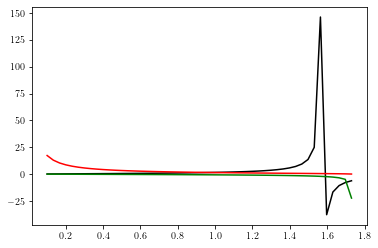

In [120]:
v0 = 3
N  = int(np.sqrt(v0)) + 1
# for i in range(1,N+1):
k  = np.linspace(0.1,0.999*np.sqrt(v0))
plt.plot(k,np.tan(k),'k')
plt.plot(k,np.sqrt(v0/k**2-1),'r')
plt.plot(k,-1/np.sqrt(v0/k**2-1),'g')

# plt.ylim(0)

plt.show()

### numerical stuff

-- to do: comparison with analytic solutions (transcendental equation for even/odd solutions, how many solutions exist)

In [4]:
def V(t,a=1,V0=1):
    temp = -V0*(np.abs(t) < a).astype(float) + V0
    return temp

In [52]:
x,E,psi = solve_SE(-10,10,100,lambda t: V(t,a=2,V0=4))

In [53]:
E[:10]/E[0]

array([ 1.        ,  3.95369626,  8.69944697, 14.80934435, 18.85943764,
       18.92912556, 19.71516557, 20.02177755, 20.98350191, 21.77338034])

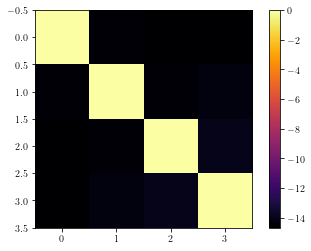

In [54]:
img = plt.imshow(np.log10(np.abs(psi[:4]@psi[:4].T)),cmap='inferno')
plt.colorbar(img)
plt.show()

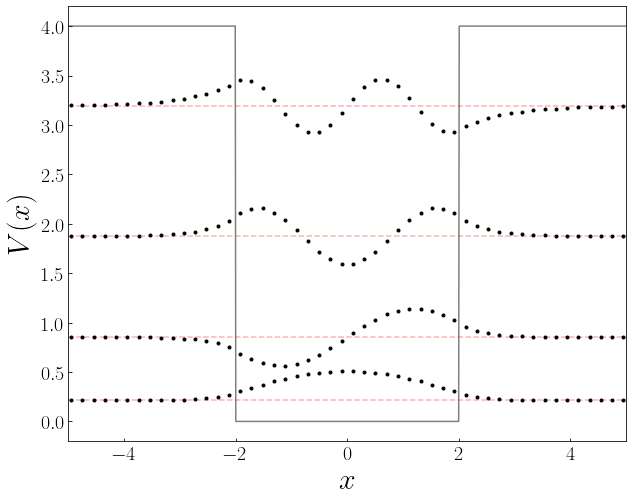

In [56]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-5,5,1000)
ax.plot(x_,V(x_,a=2,V0=4),color='k',alpha=0.5)

for i in range(4):
    ax.axhline(E[i],color='r',ls='--',alpha=0.3)
    ax.plot(x,psi[i] + E[i],'k.')

# ax.axhline(E[1],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[1] + E[1])

# ax.axhline(E[2],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[2] + E[2])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[3])

ax.set_xlim(-5,5)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.plot(x,psi[0])
ax.plot(x,psi[1])
# ax.plot(x,psi[2])
# ax.plot(x,psi[3])
# ax.plot(x,psi[4])

plt.show()

# Harmonic oscillator

In [ ]:
def V(t,m=1,w=1):
    return 0.5*m*w**2*t**2

In [ ]:
x,E,psi = solve_SE(-5,5,1000,V)

In [ ]:
E[:10]

In [ ]:
img = plt.imshow(np.log10(np.abs(psi@psi.T)),cmap='inferno')
plt.colorbar(img)

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-5,5,1000)
ax.plot(x_,V(x_),color='k',alpha=0.5)


for i in range(12):
    ax.axhline(E[i],color='r',ls='--',alpha=0.3)
    ax.plot(x,5*psi[i] + E[i],'k-')

# ax.axhline(E[1],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[1] + E[1])

# ax.axhline(E[2],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[2] + E[2])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[3])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[4])

ax.set_xlim(-5,5)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.plot(x,psi[0])
ax.plot(x,psi[1])
ax.plot(x,psi[2])
# ax.plot(x,psi[3])
# ax.plot(x,psi[4])

plt.show()

# Morse Potential

In [ ]:
def V(t,D=20,x0=1.5,a=0.5):
    return D*(1-np.exp(-a*(t-x0)))**2

In [ ]:
x,E,psi = solve_SE(0,3,100,V)

In [ ]:
E[:10]

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(0,3,1000)
ax.plot(x_,V(x_),color='k',alpha=0.5)


for i in range(4):
    ax.axhline(E[i],color='r',ls='--',alpha=0.3)
    ax.plot(x,5*psi[i] + E[i])

# ax.axhline(E[1],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[1] + E[1])

# ax.axhline(E[2],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[2] + E[2])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[3])

# ax.axhline(E[3],color='r',ls='--',alpha=0.3)
# ax.plot(x,5*psi[3] + E[4])

ax.set_xlim(0,3)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.plot(x,psi[0])
ax.plot(x,psi[1])
ax.plot(x,psi[2])
# ax.plot(x,psi[3])
# ax.plot(x,psi[4])

plt.show()